# Sensitivies in Black-Scholes model

We calculate the delta, gamma, and vega sensitivities for multi-asset call option in Black-Scholes model. The sensitivities are estimated using smart bump method, linear regression, AAD, AAD with bump method, then compared with the analytical results. 

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import torch
from torch import nn
from torch.nn import functional as F
import tqdm

device_str = 'cuda:0'
device = torch.device(device_str)

from functorch import jacfwd, hessian as ft_hessian


# Simulating payoffs

Simulate the Black-Scholes call payoffs of `d` assets using following parameters:
* `S0`: initial prices of assets
* `sigma0`: volatilities
* `N`: number of simulation paths
* `K`: strike
* `T`: maturity
* `r`: interest rate

To estimate sensitivities, `S0` and `sigma0` receives pathwise i.i.d. centered Gaussian perturbation of strength `amp`. `generate_mix_naive()` generate the relative perturbation for all parameters in all paths, while `generate_mix()` generate perturbations for `S0` in a half of paths and generate perturbations for `sigma0` in the other half.


In [2]:
d = 3
amp = 0.03

In [3]:
def generate_mix(N, seed=1):
    a = amp*np.random.RandomState(seed = seed).multivariate_normal(np.zeros(d), np.eye(d), size = (N//2,))
    b = amp*np.random.RandomState(seed = seed+1 if seed is not None else seed).multivariate_normal(np.zeros(d), np.eye(d), size = (N//2,))
    n = np.concatenate([np.concatenate([a, np.zeros_like(a)], axis = 1), np.concatenate([np.zeros_like(b), b], axis = 1)],axis = 0)
    return torch.tensor(n, dtype=torch.float32, device=device_str)

def generate_mix_naive(N, seed=1):
    a = amp*np.random.RandomState(seed = seed).multivariate_normal(np.zeros(d*2), np.eye(d*2), size = (N,))
    return torch.tensor(a, dtype=torch.float32, device=device_str)

def generate_S0_callpayoff(S0, sigma0, N, K, T, r, mixture_noise, seed_omega=0):
    mixture_noise_torch = torch.tensor(mixture_noise, dtype=torch.float32, device=device_str)
    S0 = S0*(1+mixture_noise_torch[:, :d])
    sigma0 = sigma0*(1+mixture_noise_torch[:, d:])
    omega = np.random.RandomState(seed=seed_omega).multivariate_normal(np.zeros(d), np.eye(d), size = (N,))
    omega_torch =  torch.tensor(omega, dtype=torch.float32, device=device_str)
    ST = S0*torch.exp((r-0.5*(sigma0)**2)*T+(sigma0)*math.sqrt(T)*omega_torch)
    payoff = math.exp(-r*T)*torch.relu(torch.exp(torch.log(ST).mean(dim=1, keepdim=True)) - K)
    return S0, sigma0, payoff


In [4]:
K = 100
S0 = np.random.RandomState(seed = 9999).uniform(90, 110, size=(1,d))
S0 = torch.tensor(S0, dtype=torch.float32, device=device_str)
T = 1.
r = 0.0
sigma0 = np.random.RandomState(seed = 9999).uniform(0.2, 0.5, size=(1,d))
sigma0 = torch.tensor(sigma0, dtype=torch.float32, device=device_str)
N = 100000

rho = generate_mix(N,seed = 99)

rho_naive = generate_mix_naive(N,seed = 99)

S_naive, sigma_naive, payoff_naive = generate_S0_callpayoff(S0, sigma0, N, K, T, r, mixture_noise= rho_naive, seed_omega=10 )

S, sigma, payoff = generate_S0_callpayoff(S0, sigma0, N, K, T, r, mixture_noise= rho, seed_omega=10 )
_, _, payoff_b =  generate_S0_callpayoff(S0, sigma0, N, K, T, r, mixture_noise= -rho, seed_omega=10 )
_, _, payoff_0 =  generate_S0_callpayoff(S0, sigma0, N, K, T, r, mixture_noise= 0*rho, seed_omega=10 )

/tmp/ipykernel_1985107/3687361486.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mixture_noise_torch = torch.tensor(mixture_noise, dtype=torch.float32, device=device_str)


# Analytical sensitivity computation

In [5]:
def BS_Delta(S, sigma):
    sigma_forward= torch.sqrt((sigma**2).sum(dim = 1,keepdim = True))/d
    S_forward = torch.exp((torch.log(S) + (-sigma**2/2+ sigma_forward**2/2)*T).mean(dim = 1 , keepdim = True))

    d1 = (torch.log(S_forward/K) + (r+sigma_forward**2/2)*T)/(sigma_forward*math.sqrt(T))
    delta = stats.norm.cdf(d1.cpu())*S_forward.cpu().numpy()/d/S.cpu().numpy()
    
    return delta

def BS_Gamma(S, sigma):
    sigma_forward= torch.sqrt((sigma**2).sum(dim = 1,keepdim = True))/d
    S_forward = torch.exp((torch.log(S) + (-sigma**2/2+ sigma_forward**2/2)*T).mean(dim = 1 , keepdim = True))

    d1 = (torch.log(S_forward/K) + (r+sigma_forward**2/2)*T)/(sigma_forward*math.sqrt(T))
    delta_forward = torch.tensor(stats.norm.cdf(d1.cpu())).to(sigma_forward)
    gamma_forward = torch.tensor(stats.norm.pdf(d1.cpu())).to(sigma_forward)/ (S_forward*sigma_forward*math.sqrt(T))
    
    d_Sf_S = S_forward/d/S
    dd_Sf_S = -(d-1)*S_forward/(d**2*S**2)
    
    return (delta_forward*dd_Sf_S + gamma_forward*d_Sf_S**2).cpu().numpy()


def BS_Vega(S, sigma):
    sigma_forward= torch.sqrt((sigma[:,0:d]**2).sum(dim = 1,keepdim = True))/d
    S_forward = torch.exp((torch.log(S[:,0:d]) + (-sigma[:,0:d]**2/2+ sigma_forward**2/2)*T).mean(dim = 1 , keepdim = True))
    
    d1 = (torch.log(S_forward/K) + (r+sigma_forward**2/2)*T)/(sigma_forward*math.sqrt(T))
    vega_forward = torch.tensor(S_forward.cpu().numpy() * stats.norm.pdf(d1.cpu()) * np.sqrt(T)).to(sigma_forward)
    delta_forward =  torch.tensor(stats.norm.cdf(d1.cpu())).to(sigma_forward)#*S_forward.cpu().numpy()
    
    dd = (d-1)/d**2
    
    vega = vega_forward*sigma[:,0:d]/(sigma_forward*d**2) - delta_forward*dd*T*sigma[:,0:d]*torch.exp(torch.log(S[:,0:d]).mean(dim = 1 , keepdim = True)-
                                                                                              dd/2*T*(sigma[:,0:d]**2).sum(dim = 1 , keepdim = True) )
    return vega.detach().cpu().numpy()

In [6]:
true_sensis = np.concatenate([BS_Delta(S0, sigma0), BS_Vega(S0, sigma0),  BS_Gamma(S0, sigma0)]).ravel()

# Smart bump sensis

Bump sensitivities with $N/2d$ paths.

In [7]:
def generate_bump(N, i, sign):
    n = torch.zeros((N, 2*d))
    n[:, i] = 0.01 * sign
    return n

def bump_sensis(i, S0, sigma0, N, K, T, r, seed_omega = 0):
    param = np.concatenate([S0[0, :].detach().cpu().numpy(), sigma0[0, :].detach().cpu().numpy()])[i]
    plus_noise = generate_bump(N, i, 1)
    _, _, payoff_baseline = generate_S0_callpayoff(S0, sigma0, N, K, T, r, mixture_noise=np.zeros_like(plus_noise), seed_omega=seed_omega)
    _, _, payoff_plus = generate_S0_callpayoff(S0, sigma0, N, K, T, r, mixture_noise=plus_noise, seed_omega=seed_omega)
    _, _, payoff_minus = generate_S0_callpayoff(S0, sigma0, N, K, T, r, mixture_noise=-plus_noise, seed_omega=seed_omega)
    samples = (payoff_plus.detach().cpu().numpy() - payoff_minus.detach().cpu().numpy()) / 0.02 / param
    samples_gamma = (payoff_plus.detach().cpu().numpy() + payoff_minus.detach().cpu().numpy() - 2 * payoff_baseline.detach().cpu().numpy()) / (0.01 * param)**2
    return samples.mean(), samples.std() / np.sqrt(N), samples_gamma.mean(), samples_gamma.std() / np.sqrt(N)

In [8]:
smart_bump_sensis = []
smart_bump_se = []
smart_bump_gamma = []
smart_bump_gamma_se = []
for i in range(2*d):
    sensis, se, gamma, gamma_se = bump_sensis(i, S0, sigma0, N // (2 * d), K, T, r, seed_omega=10)
    smart_bump_sensis.append(sensis)
    smart_bump_se.append(se)
    smart_bump_gamma.append(gamma)
    smart_bump_gamma_se.append(gamma_se)
smart_bump_sensis = np.array(smart_bump_sensis)
smart_bump_se = np.array(smart_bump_se)
smart_bump_gamma = np.array(smart_bump_gamma)
smart_bump_gamma_se = np.array(smart_bump_gamma_se)

/tmp/ipykernel_1985107/3687361486.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mixture_noise_torch = torch.tensor(mixture_noise, dtype=torch.float32, device=device_str)


# Linear regression

Calculating sensitivities by regressing the cashflow against `S0` and `sigma0`. In practice, we use the difference between the perturbed and inversly perturbed (or unperturbed) quantities in the regression to improve performance. The linear regression problem is solved by explicit formula $\mathbb{E}[XX]^{-1}\mathbb{E}[XY]$ (where $X$ denotes feature and $Y$ denotes label). As we generate the perturbation for the features, $\mathbb{E}[XX]$ can be calculated analytically.

In [9]:
features = torch.cat([S, sigma], dim=1).cpu().numpy()
features0 = torch.cat([S0, sigma0], dim=1).cpu().numpy()
labels = payoff.cpu().numpy()
labels_b = payoff_b.cpu().numpy()
labels_0 = payoff_0.cpu().numpy()

In [10]:
XY = (features-features0) * (labels-labels_b)

XY_sum = XY.sum(axis=0)
XY_se = XY.std(axis=0) * np.sqrt(N)
rel_se_reg = (XY_se / XY_sum)
cov_theory = np.concatenate([S0.detach().cpu().numpy() ** 2 * amp ** 2 * N / 2, sigma0.detach().cpu().numpy() ** 2 * amp ** 2 * N / 2], axis=1)
reg_sensis = (XY_sum / cov_theory / 2)[0, :]

In [11]:
XY_gamma = (labels+labels_b-2*labels_0)[0:N//2] * (features-features0)[0:N//2,0:d]**2
XY_gamma_sum = XY_gamma.sum(axis=0)
cov_theory_gamma_diag = np.array([S0.detach().cpu().numpy() ** 4 * amp ** 4 * 3 * N / 2])[0, 0]
cov_theory_gamma = np.zeros((d, d))
for i in range(d):
    cov_theory_gamma[i, i] = cov_theory_gamma_diag[i]
for i in range(d):
    for j in range(i):
        cov_theory_gamma[i, j] = S0[0, i] ** 2 * S0[0, j] ** 2 * amp**4 * N / 2
        cov_theory_gamma[j, i] = S0[0, i] ** 2 * S0[0, j] ** 2 * amp**4 * N / 2
inv_cov_theory_gamma = np.linalg.inv(cov_theory_gamma)
reg_gamma = inv_cov_theory_gamma @ XY_gamma_sum
se_reg_gamma = (inv_cov_theory_gamma @ XY_gamma.T).std(axis=1) * np.sqrt(XY_gamma.shape[0])

# AAD

Learn the price of call option using a neural network, then calculate the sensis with AAD. The training error is captured by iterative training with different initialization. The AAD bump method using the difference between perturbed and unperturbed cashflow as training labels, while the naive AAD method using perturbed cashflow themselves as training labels.

In [12]:
class FeedforwardNeuralNetwork(torch.nn.Module ):
    def __init__(self, dim = 2*d, activation_func = F.softplus):
        super().__init__()
        self.W1 = torch.nn.Parameter(torch.randn(dim, 50, dtype=torch.float32, device=device_str) * math.sqrt(2/(d+50)))
        self.W2 = torch.nn.Parameter(torch.randn(50, 50, dtype=torch.float32, device=device_str) * math.sqrt(2/(50+50)))
        self.Wout = torch.nn.Parameter(torch.randn(50, 1, dtype=torch.float32, device=device_str)* math.sqrt(2/(1+50)))
        self.b1 = torch.nn.Parameter(torch.zeros(50, dtype=torch.float32, device=device_str))
        self.b2 = torch.nn.Parameter(torch.zeros(50, dtype=torch.float32, device=device_str))
        self.bout = torch.nn.Parameter(torch.zeros(1, dtype=torch.float32, device=device_str))
        self.activation_func = activation_func
        
    def forward(self, x):
        y = self.activation_func(x @ self.W1 + self.b1)
        y = self.activation_func(y @ self.W2 + self.b2)
        y = y @ self.Wout + self.bout
        return y
    
    def predict(self, S,sigma):
        features = torch.cat([S, sigma], 1) if sigma is not None else S
        return self.forward((features-self.features_mean)/self.features_std)
        
    def fit(self, S, sigma, labels, lr = 0.01, wd = 0.01, epochs =1000) :

        train_losses = []
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=wd)
        loss = lambda y1, y2: ((y1 - y2)**2).mean()


        features = torch.cat([S, sigma], 1) if sigma is not None else S
        self.features_mean = features.mean(dim = 0)
        self.features_std = features.std(dim = 0)
        self.label_var = labels.var()
        for e in range(epochs):
            self.train()
            pred = self((features-self.features_mean)/self.features_std)
            train_loss = loss(pred, labels) / self.label_var
            
            self.optimizer.zero_grad()
            train_loss.backward()
            self.optimizer.step()
            self.eval()
  
            train_losses.append(train_loss.item())


In [13]:
list_naive_aad_sensi = list()

for _ in tqdm.tqdm(range(100)):
    model = FeedforwardNeuralNetwork(activation_func = F.relu)
    model.fit(S_naive, sigma_naive, payoff_naive, wd = 0.001)
    dv_sensis = torch.cat(jacfwd(model.predict, argnums=(0,1))(S0,sigma0)).ravel()
    g_aad_sensis = ft_hessian(model.predict, argnums=0)(S0,sigma0).squeeze().diagonal()
    aad_sensis = torch.cat([dv_sensis, g_aad_sensis]).detach().cpu().numpy().ravel()
    list_naive_aad_sensi.append(aad_sensis)

  0%|          | 0/100 [00:00<?, ?it/s]/home/botaoli/miniconda3/envs/general/lib/python3.11/site-packages/torch/_functorch/deprecated.py:88: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacfwd is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacfwd instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacfwd')
/home/botaoli/miniconda3/envs/general/lib/python3.11/site-packages/torch/_functorch/deprecated.py:92: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.hessian is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.hessian instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/d

In [14]:
list_aad_sensi = list()
for _ in tqdm.tqdm(range(100)):
    model = FeedforwardNeuralNetwork()
    model.fit(S, sigma, payoff - payoff_b, wd=0.001)    
    dv_sensis = torch.cat(jacfwd(model.predict, argnums=(0,1))(S0,sigma0)).ravel()
    g_aad_sensis = ft_hessian(model.predict, argnums=0)(S0,sigma0).squeeze().diagonal()
    aad_sensis = torch.cat([dv_sensis, g_aad_sensis]).detach().cpu().numpy().ravel()/2
    list_aad_sensi.append(aad_sensis)

100%|██████████| 100/100 [03:32<00:00,  2.12s/it]


In [15]:
mean_aad_sensi = np.array(list_aad_sensi).mean(axis=0)
std_aad_sensi = np.array(list_aad_sensi).std(axis=0)

mean_naive_aad_sensi = np.array(list_naive_aad_sensi).mean(axis=0)
std_naive_aad_sensi = np.array(list_naive_aad_sensi).std(axis=0)

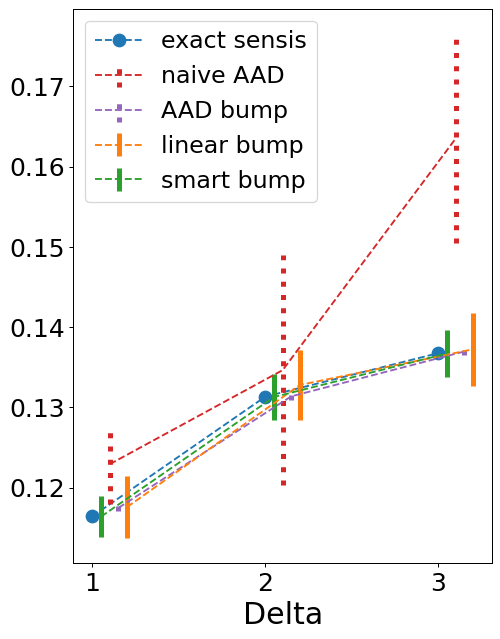

In [16]:
from matplotlib.ticker import MaxNLocator

shift_scale = 0.05

f = plt.figure(figsize=(6,8), dpi = 90, facecolor='white')
ax = f.gca()

plt.plot(np.arange(1,d+1), true_sensis[0:d], linestyle='--', marker='o', label='exact sensis', markersize =10, color='C0')
a = plt.errorbar(np.arange(1,d+1)+2*shift_scale, mean_naive_aad_sensi[0:d], yerr=1.96*std_naive_aad_sensi[0:d],linestyle='--', label='naive AAD', elinewidth=4, color='C3')
b = plt.errorbar(np.arange(1,d+1)+3*shift_scale, mean_aad_sensi[0:d], yerr=1.96*std_aad_sensi[0:d], linestyle='--', label='AAD bump', elinewidth=4, color='C4')
plt.errorbar(np.arange(1,d+1)+4*shift_scale, reg_sensis[0:d], yerr=1.96*(rel_se_reg * reg_sensis)[0:d], linestyle='--', label='linear bump', elinewidth=4, color='C1')
a[-1][0].set_linestyle(':')
b[-1][0].set_linestyle(':')
plt.errorbar(np.arange(1,d+1)+shift_scale, smart_bump_sensis[0:d], yerr=1.96*smart_bump_se[0:d], linestyle='--', label='smart bump', elinewidth=4, color='C2')

plt.legend(loc = 'upper left',fontsize=19)
plt.xlabel('Delta', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.savefig('BS_delta.pdf')
plt.show()

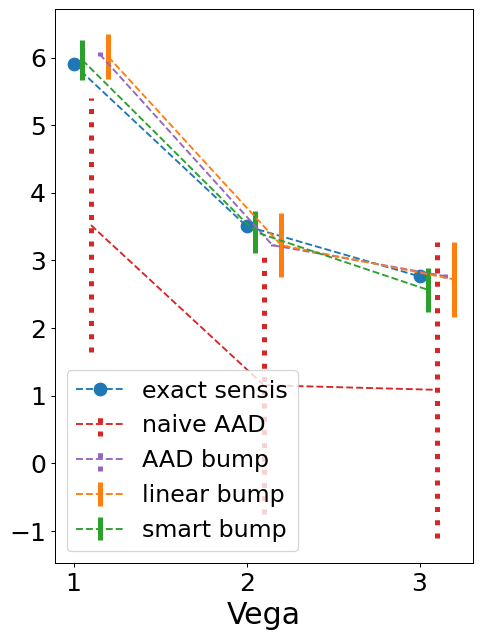

In [17]:
from matplotlib.ticker import MaxNLocator

f = plt.figure(figsize=(6,8), dpi = 90, facecolor='white')
ax = f.gca()

plt.plot(np.arange(1,d+1), true_sensis[d:2*d], linestyle='--', marker='o', label='exact sensis', markersize=10)
a = plt.errorbar(np.arange(1,d+1)+2*shift_scale, mean_naive_aad_sensi[d:2*d], yerr=1.96*std_naive_aad_sensi[d:2*d],linestyle='--', label='naive AAD', elinewidth=4, color='C3')
b = plt.errorbar(np.arange(1,d+1)+3*shift_scale, mean_aad_sensi[d:2*d], yerr=1.96*std_aad_sensi[d:2*d], linestyle='--', label='AAD bump', elinewidth=4, color='C4')
plt.errorbar(np.arange(1,d+1)+4*shift_scale, reg_sensis[d:2*d], yerr=1.96*(rel_se_reg * reg_sensis)[d:2*d], linestyle='--', label='linear bump', elinewidth=4, color='C1')
plt.errorbar(np.arange(1,d+1)+shift_scale, smart_bump_sensis[d:2*d], yerr=1.96*smart_bump_se[d:2*d], linestyle='--', label='smart bump', elinewidth=4, color='C2')

a[-1][0].set_linestyle(':')
b[-1][0].set_linestyle(':')

plt.legend(loc = 'lower left',fontsize = 19)
plt.xlabel('Vega', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.savefig('BS_vega.pdf')
plt.show()

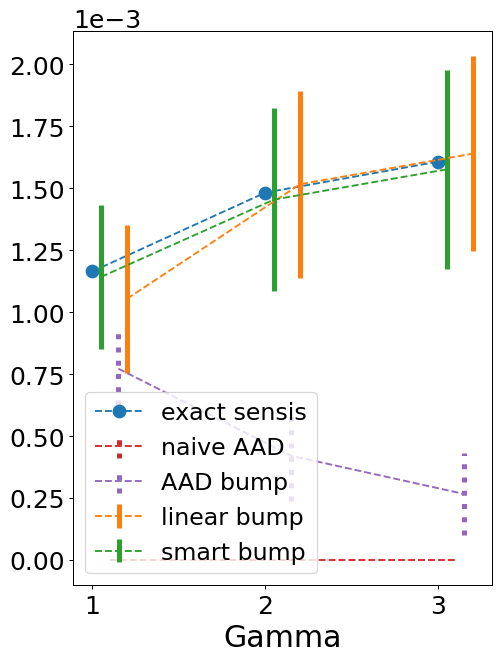

In [18]:
from matplotlib.ticker import MaxNLocator

f = plt.figure(figsize=(6,8), dpi = 90, facecolor='white')
ax = f.gca()

plt.plot(np.arange(1,d+1), true_sensis[2*d:], linestyle='--', marker='o', label='exact sensis', markersize=10)
a = plt.errorbar(np.arange(1,d+1)+2*shift_scale, mean_naive_aad_sensi[2*d:], yerr=1.96*std_naive_aad_sensi[2*d:], linestyle ='--', label='naive AAD', elinewidth=4, color='C3')
b = plt.errorbar(np.arange(1,d+1)+3*shift_scale, mean_aad_sensi[2*d:], yerr=1.96*std_aad_sensi[2*d:], linestyle='--', label='AAD bump', elinewidth=4, color='C4')
a[-1][0].set_linestyle(':')
b[-1][0].set_linestyle(':')
plt.errorbar(np.arange(1,d+1)+4*shift_scale, reg_gamma, yerr=1.96*se_reg_gamma, linestyle='--', label='linear bump', elinewidth=4, color='C1')
plt.errorbar(np.arange(1,d+1)+shift_scale, smart_bump_gamma[:d], yerr=1.96*np.array(smart_bump_gamma_se)[:d], linestyle='--', label='smart bump', elinewidth=4, color='C2')


plt.legend(loc='lower left',fontsize=19)
plt.xlabel('Gamma', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.yaxis.get_offset_text().set_fontsize(20)
plt.savefig('BS_gamma.pdf')
plt.show()